# Hosting Detectron2 model on Sagemaker Inference endpoint

In this notebook we'll package previously trained model into PyTorch Serving container and deploy it on Sagemaker. First, let's review serving container. There are two key difference comparing to training container:
- we are using different base container provided by Sagemaker;
- we need to start Web server (refer to ENTRYPOINT command).

## Compiling Serving Container

In [ ]:
! pygmentize -l docker Dockerfile.serving

As in case of training image, we'll need to build and push container to AWS ECR. Before this, we'll need to loging to shared Sagemaker ECR and your local ECR

In [ ]:
# loging to Sagemaker ECR with Deep Learning Containers
!aws ecr get-login-password --region us-east-2 | docker login --username AWS --password-stdin 763104351884.dkr.ecr.us-east-2.amazonaws.com
# loging to your private ECR
!aws ecr get-login-password --region us-east-2 | docker login --username AWS --password-stdin 553020858742.dkr.ecr.us-east-2.amazonaws.com

Now, let's build and push container using follow command. Note, that here we supply non-default Dockerfile.

In [ ]:
! ./build_and_push.sh d2-sm-coco-serving latest Dockerfile.serving

## Preparing test data

We'll be using coco2017 validation dataset. To simplify working with it, let's install locally Pycoco package

In [ ]:
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [ ]:
!pip install -U scikit-image

In [ ]:
!pip install google-colab # needed for image rendering

Now, let's download Coco2017 validation dataset

In [ ]:
data_dir = "../datasets/coco/" # folder where data will be saved
dataset  = "val2017"

In [ ]:
! mkdir -p {data_dir}{dataset}
! wget http://images.cocodataset.org/zips/val2017.zip -P {data_dir}
! unzip {data_dir}/val2017.zip -d {data_dir}

In [ ]:
! wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P {data_dir}
! unzip {data_dir}/annotations_trainval2017.zip -d {data_dir}{dataset}

Let's get a random image ...

In [ ]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

annFile='{}{}/annotations/instances_{}.json'.format(data_dir,dataset, dataset)
coco=COCO(annFile)

# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog']);
imgIds = coco.getImgIds(catIds=catIds);
imgId = imgIds[np.random.randint(len(imgIds))]
image_instance = coco.loadImgs(imgId)[0]
image_np = io.imread(image_instance['coco_url'])    

In [ ]:
plt.axis('off')
plt.imshow(image_np)
plt.show()

# Testing inference script locally

Let's first check what inference script we'll deploy:

In [ ]:
!pygmentize container_serving/predict_coco.py

To test inference pipeline locally, you can run your `container_serving/predict_coco.py` locally (only code in __main__ guard will be executed). You'll need to have Detectron2 and number other packages locally installed to test it.

Make sure that you pass correct --model-dir argument.

In [ ]:
!python container_serving/predict_coco.py --image container_serving/coco_sample.jpg --model-dir ../trained_model

# Deploying Inference Endpoint

Below is some initial imports and configuration.

In [68]:
import boto3
import re

import os
import numpy as np
import pandas as pd
from sagemaker import get_execution_role
import requests
import json
import pickle
import detectron2 
from container_serving.d2_deserializer import json_to_d2

role = get_execution_role()

In [42]:
import sagemaker
from time import gmtime, strftime

sess = sagemaker.Session() # can use LocalSession() to run container locally

bucket = sess.default_bucket()
region = "us-east-2"
account = sess.boto_session.client('sts').get_caller_identity()['Account']
prefix_input = 'detectron2-input'
prefix_output = 'detectron2-ouput'

In [ ]:
# This is needed to register Detectron metadata catalog.

from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
r = register_coco_instances("coco2017", {}, "json_annotation_val.json", "../datasets/coco/val2017")
metadata = MetadataCatalog.get("coco2017")

## Define parameters of your container

In [43]:
container_serving = "d2-sm-coco-serving" # your container name
tag = "latest" # you can have several version of container available
image = '{}.dkr.ecr.{}.amazonaws.com/{}:{}'.format(account, region, container_serving, tag)

print("Following container will be used for hosting: ",image)

Following container will be used for hosting:  553020858742.dkr.ecr.us-east-2.amazonaws.com/d2-sm-coco-serving:latest


## Deploy endpoint locally

As training on COCO2017 can be quite lenghty, we'll deploy our endpoint from model artifacts from already completed training jobs. Please review your training jobs, and find one which succesffuly completed. Then, copy model artifact S3 URI and.  pass it to `model_data` argument below.

In [ ]:
from sagemaker.pytorch import PyTorchModel, PyTorch, PyTorchPredictor
from sagemaker import Model


model = PyTorchModel(
                     name = "local-1",
                     model_data="s3://sagemaker-us-east-2-553020858742/detectron2-model/R101-FPN-v2.tar.gz",
                     role=role,
                     entry_point="predict_coco.py", source_dir="container_serving",
                     framework_version="1.4", py_version="3.6",
                     image=image)

In [ ]:
predictor = model.deploy(
                         instance_type = 'local_gpu',
                         initial_instance_count=1,
                         endpoint_name=f"{container_serving}-{tag}-local-1", # define a unqie endpoint name; if ommited, Sagemaker will generate it based on used container
                         tags=[{"Key":"image", "Value":f"{container_serving}:{tag}"}], 
                         wait=False
                         )

In [ ]:
pred_image = 'coco_sample.jpg'
url = 'http://172.18.0.2:8080/invocations' # IP address of serving container when deployed locally
content_type = 'jpeg'
accept_type = "json" # "json" or "detectron2". For instance segmentation, 'detectron2' is not supported.
headers = {'content-type': content_type, 'accept': accept_type}
payload = open('coco_sample.jpg', 'rb')
device = 'cuda:0'

response = requests.post(url, data=payload, headers=headers)

if accept_type=="json":
    predictions = json.loads(response.content)
    predictions = json_to_d2(predictions, device)
elif accept_type=="detectron2":
    predictions = pickle.loads(response.content)

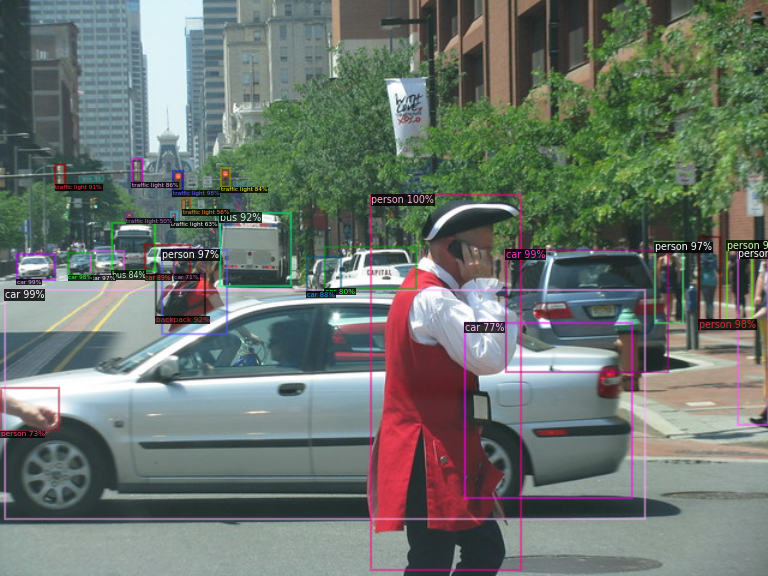

In [65]:
from detectron2.utils.visualizer import ColorMode, Visualizer
import cv2
from google.colab.patches import cv2_imshow


im = cv2.imread(pred_image)

v = Visualizer(im[:, :, ::-1],
               metadata=MetadataCatalog.get("coco_2017_train"), 
               scale=1.2, 
)
v = v.draw_instance_predictions(predictions["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

## Deploy remote endpoint

To process inference data when we are sending it over internet, we need to have two customer ser/deser methods.

In [44]:
from sagemaker.pytorch import PyTorchModel, PyTorch, PyTorchPredictor
from sagemaker.estimator import Estimator, Model

remote_model = PyTorchModel(
                     name = "d2-service", 
                     model_data="s3://sagemaker-us-east-2-553020858742/detectron2-model/R101-FPN-v2.tar.gz", # from training job
                     role=role,
                     entry_point="predict_coco.py", source_dir="container_serving",
                     framework_version="1.4", py_version="3.6",
                     image=image)

In [45]:
endpoint_name = f"{container_serving}-{tag}"

remote_predictor = remote_model.deploy(
                         instance_type='ml.p3.16xlarge', 
                         initial_instance_count=1,
                         endpoint_name=endpoint_name, # define a unqie endpoint name; if ommited, Sagemaker will generate it based on used container
                         tags=[{"Key":"image", "Value":f"{container_serving}:{tag}"}], 
                         wait=False
                         )

In [66]:
# Let's get another image to predict

! wget http://farm6.staticflickr.com/5290/5382403037_73709768a2_z.jpg

--2020-05-01 16:40:27--  http://farm6.staticflickr.com/5290/5382403037_73709768a2_z.jpg
Resolving farm6.staticflickr.com (farm6.staticflickr.com)... 99.86.58.167, 2600:9000:2132:a00:0:5a51:64c9:c681, 2600:9000:2132:1800:0:5a51:64c9:c681, ...
Connecting to farm6.staticflickr.com (farm6.staticflickr.com)|99.86.58.167|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://farm6.staticflickr.com/5290/5382403037_73709768a2_z.jpg [following]
--2020-05-01 16:40:27--  https://farm6.staticflickr.com/5290/5382403037_73709768a2_z.jpg
Connecting to farm6.staticflickr.com (farm6.staticflickr.com)|99.86.58.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘5382403037_73709768a2_z.jpg.2’

5382403037_73709768     [ <=>                ] 188.54K  --.-KB/s    in 0.05s   

2020-05-01 16:40:28 (3.52 MB/s) - ‘5382403037_73709768a2_z.jpg.2’ saved [193060]



In [69]:
import boto3
from io import BytesIO

pred_image = '5382403037_73709768a2_z.jpg'

client = boto3.client('sagemaker-runtime')
accept_type = "json"
content_type = 'image/jpeg'
headers = {'content-type': content_type}
payload = open(pred_image, 'rb')
endpoint_name = "d2-sm-coco-serving-latestv8"
device = "cuda:0"

response = client.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=payload,
    ContentType=content_type,
    Accept = accept_type
)

if accept_type=="json":
    predictions = json.loads(response['Body'].read())
    predictions = json_to_d2(predictions, device)
elif accept_type=="detectron2":
    print(response['Body'].read())
    stream = BytesIO(response['Body'].read())
    predictions = pickle.loads(stream.read())


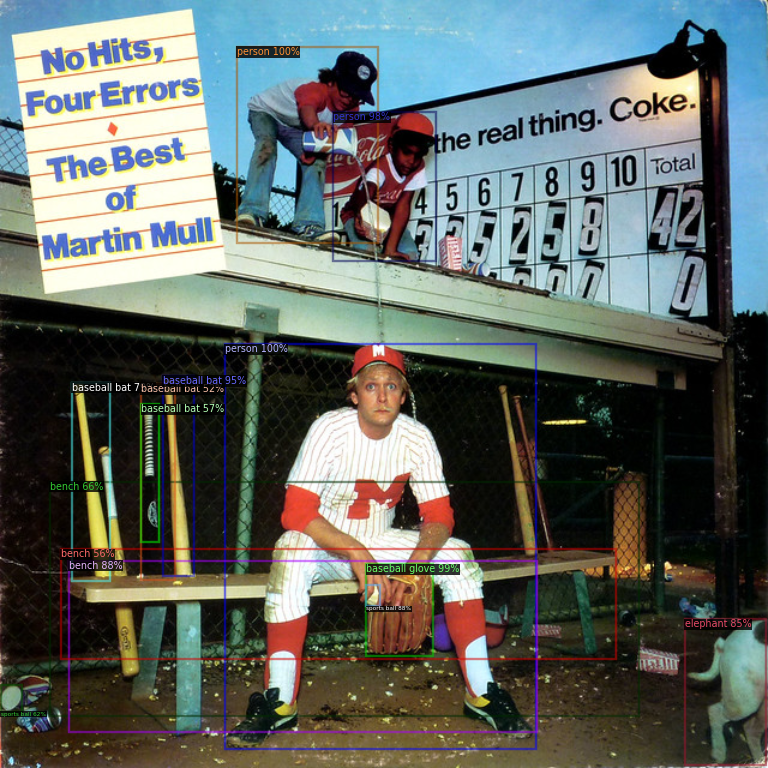

In [70]:
from detectron2.utils.visualizer import ColorMode, Visualizer
import cv2
from google.colab.patches import cv2_imshow

im = cv2.imread(pred_image)

v = Visualizer(im[:, :, ::-1],
               metadata=MetadataCatalog.get("coco_2017_train"), 
               scale=1.2, 
)
v = v.draw_instance_predictions(predictions["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
predictor.delete_endpoint()